In [1]:
import time
import spo
import torch
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

## Init Data

In [2]:
# generate data for grid network (features and costs)
m = 20 # number of nodes
n = 1000 # number of data
p = 10 # size of feature
deg = 4 # polynomial degree
x, c = spo.data.tsp.genData(n+1000, p, m, deg=deg, noise_width=0)

## Optimization model

In [3]:
tsp_model = spo.model.tspModel(m)

Academic license - for non-commercial use only - expires 2021-08-20
Using license file C:\Users\Apocrypse\gurobi.lic


In [4]:
# solve
tsp_model.setObj(c[0])
sol, obj = tsp_model.solve()
print('Obj: {}'.format(obj))
tour = tsp_model.getTour(sol)
print(' -> '.join(map(str, tour)))

Obj: 2857.4326
0 -> 2 -> 15 -> 18 -> 19 -> 8 -> 12 -> 14 -> 3 -> 16 -> 4 -> 13 -> 7 -> 9 -> 1 -> 11 -> 17 -> 5 -> 6 -> 10 -> 0


## Data Loader

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [6]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [7]:
# get training data set
tsp_dataset_train = spo.data.dataset.optDataset(tsp_model, x_train, c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 60.61it/s]


In [8]:
# get test data set
tsp_dataset_test = spo.data.dataset.optDataset(tsp_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.19it/s]


In [9]:
# get data loader
batch_size = 32
tsp_loader_train = DataLoader(tsp_dataset_train, batch_size=batch_size, shuffle=True)
tsp_loader_test = DataLoader(tsp_dataset_test, batch_size=batch_size, shuffle=False)

In [10]:
for i, data in enumerate(tsp_loader_train):
    x, c, w, z = data
    break

In [11]:
x.shape

torch.Size([32, 10])

In [12]:
c.shape

torch.Size([32, 190])

In [13]:
w.shape

torch.Size([32, 190])

In [14]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [17]:
# build model
twostage_model = spo.twostage.sklearnPred(reg, tsp_model)

In [18]:
# training
twostage_model.fit(tsp_dataset_train.x, tsp_dataset_train.c)

In [19]:
# prediction
c_test_pred = twostage_model.predict(tsp_dataset_test.x)

In [20]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = tsp_dataset_test.c[i]
    z_true_i = tsp_dataset_test.z[i,0]
    truespo += spo.eval.calTrueSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
    unambspo += spo.eval.calUnambSPO(tsp_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print('Normalized true SPO Loss: {:.2f}%'.format(truespo / abs(tsp_dataset_test.z.sum()) * 100))
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(unambspo / abs(tsp_dataset_test.z.sum()) * 100))

100%|██████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.28it/s]


Normalized true SPO Loss: 7.11%
Normalized unambiguous SPO Loss: 7.11%


In [21]:
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        tour = tsp_model.getTour(w[j])
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(z[j,0]))
        tour = tsp_model.getTour(wpj)
        print('    True sol: ' + ' -> '.join(map(str, tour)) + ', True obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 510.54, 240.54, 425.23, 346.94, 190.01, 272.81, 558.04, 257.74, 748.21, 705.20, 400.67, 285.04, 327.34, 388.62, 264.83, 538.92, 250.46, 443.52, 573.44, 870.94, 405.03, 133.36, 313.34, 326.11, 207.68, 640.30, 180.61, 568.82, 58.08, 210.94, 216.72, 191.75, 477.81, 697.08, 208.33, 801.90, 346.39, 352.40, 633.06, 267.44, 164.57, 666.08, 742.24, 391.72, 359.80, 366.57, 255.60, 451.19, 688.17, 1608.91, 434.93, 312.29, 208.23, 365.98, 353.15, 770.93, 394.42, 1054.78, 858.68, 611.63, 438.53, 104.95, 321.51, 323.97, 141.63, 405.05, 162.40, 327.39, 324.25, 406.04, 677.46, 424.59, 255.37, 501.97, 120.71, 324.15, 219.81, 296.20, 140.74, 445.24, 575.12, 221.93, 293.46, 418.97, 356.55, 218.89, 244.78, 358.14, 325.19, 103.06, 502.42, 286.98, 329.47, 504.25, 268.59, 393.21, 186.86, 325.65, 494.09, 236.42, 356.10, 304.83, 118.94, 493.32, 195.89, 341.44, 408.49, 326.39, 483.36, 415.18, 343.98, 740.52, 557.54, 402.59, 238.60, 206.84, 555.37, 107.09, 1235.76, 1014.70, 2203.07, 100

## Linear Regression from PyTorch 

In [22]:
from torch import nn

In [23]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m*(m-1)//2)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [24]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [25]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-1)

In [26]:
# init SPO+ loss
criterion = spo.func.SPOPlus()

In [27]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(tsp_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(tsp_model, cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
        loss_log_unambspo.append(unambloss)
        print('Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%'. \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss: 6283.9209, True SPO Loss: 13.5490%, Unambiguous SPO Loss: 13.5490%
Epoch  20, Loss: 3597.7900, True SPO Loss: 10.8868%, Unambiguous SPO Loss: 10.8868%
Epoch  30, Loss: 2216.9136, True SPO Loss:  9.0902%, Unambiguous SPO Loss:  9.0902%
Epoch  40, Loss: 2073.0122, True SPO Loss:  7.5927%, Unambiguous SPO Loss:  7.5927%
Epoch  50, Loss: 1973.4241, True SPO Loss:  6.4577%, Unambiguous SPO Loss:  6.4577%
Epoch  60, Loss: 1201.6130, True SPO Loss:  5.4325%, Unambiguous SPO Loss:  5.4325%
Epoch  70, Loss: 763.6063, True SPO Loss:  4.7889%, Unambiguous SPO Loss:  4.7889%
Epoch  80, Loss: 691.6293, True SPO Loss:  4.1818%, Unambiguous SPO Loss:  4.1818%
Epoch  90, Loss: 1058.1294, True SPO Loss:  3.7179%, Unambiguous SPO Loss:  3.7179%
Epoch 100, Loss: 472.4577, True SPO Loss:  3.2602%, Unambiguous SPO Loss:  3.2602%
Epoch 110, Loss: 378.7592, True SPO Loss:  3.0065%, Unambiguous SPO Loss:  3.0065%
Epoch 120, Loss: 947.3901, True SPO Loss:  2.7259%, Unambiguous SPO Loss:  2.725

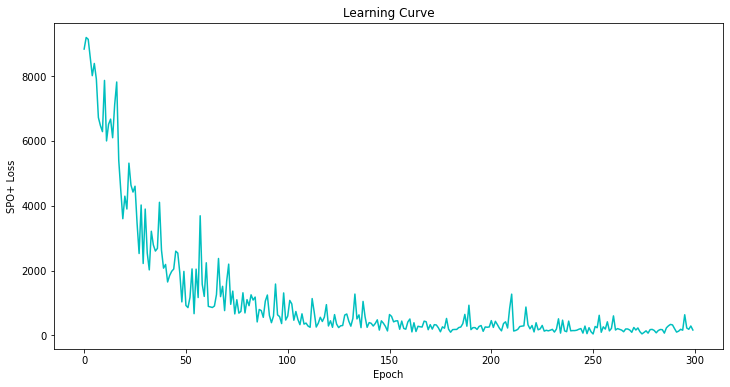

In [28]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(loss_log, color='c')
plt.xlabel('Epoch')
plt.ylabel('SPO+ Loss')
plt.title('Learning Curve')
plt.show()

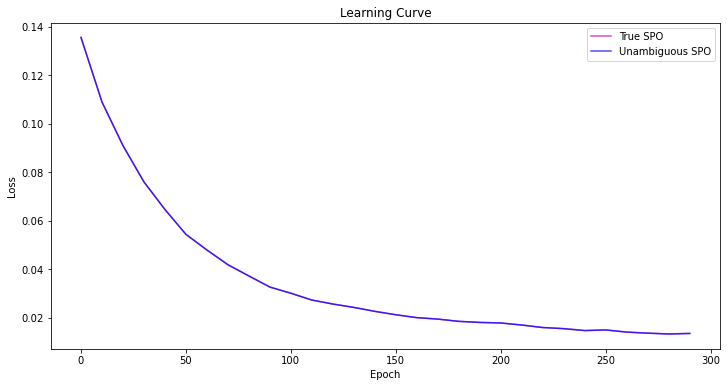

In [29]:
# draw plot
plt.figure(figsize=(12, 6))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color='m', alpha=0.7, label='True SPO')
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color='b', alpha=0.7, label='Unambiguous SPO')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [30]:
# evaluate
spoloss = spo.eval.trueSPO(reg, tsp_model, tsp_loader_test)
print('Normalized true SPO Loss: {:.2f}%'.format(spoloss * 100))
spoloss = spo.eval.unambSPO(reg, tsp_model, tsp_loader_test)
print('Normalized unambiguous SPO Loss: {:.2f}%'.format(spoloss * 100))

Normalized true SPO Loss: 1.35%
Normalized unambiguous SPO Loss: 1.35%


In [31]:
reg.eval()
# compare solutions
for i, data in enumerate(tsp_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to('cpu').detach().numpy()
    c = c.to('cpu').detach().numpy()
    w = w.to('cpu').detach().numpy()
    z = z.to('cpu').detach().numpy()
    for j in range(min(10, batch_size)):
        print('Sample {}:'.format(j))
        print('    True cost:', ', '.join(['{:.2f}'.format(cost) for cost in c[j]]))
        print('    Pred cost:', ', '.join(['{:.2f}'.format(cost) for cost in cp[j]]))
        # solve cost from prediction
        tsp_model.setObj(cp[j])
        wpj, _ = tsp_model.solve()
        zpj = np.dot(c[j], wpj)
        print('    True sol: ' + ', '.join(['{:.0f}'.format(x) for x in w[j]]) + ', True obj: {:.2f}'.format(z[j,0]))
        print('    Pred sol: '+  ', '.join(['{:.0f}'.format(x) for x in wpj]) + ', Pred obj: {:.2f}'.format(zpj))
        print()
    break

Sample 0:
    True cost: 510.54, 240.54, 425.23, 346.94, 190.01, 272.81, 558.04, 257.74, 748.21, 705.20, 400.67, 285.04, 327.34, 388.62, 264.83, 538.92, 250.46, 443.52, 573.44, 870.94, 405.03, 133.36, 313.34, 326.11, 207.68, 640.30, 180.61, 568.82, 58.08, 210.94, 216.72, 191.75, 477.81, 697.08, 208.33, 801.90, 346.39, 352.40, 633.06, 267.44, 164.57, 666.08, 742.24, 391.72, 359.80, 366.57, 255.60, 451.19, 688.17, 1608.91, 434.93, 312.29, 208.23, 365.98, 353.15, 770.93, 394.42, 1054.78, 858.68, 611.63, 438.53, 104.95, 321.51, 323.97, 141.63, 405.05, 162.40, 327.39, 324.25, 406.04, 677.46, 424.59, 255.37, 501.97, 120.71, 324.15, 219.81, 296.20, 140.74, 445.24, 575.12, 221.93, 293.46, 418.97, 356.55, 218.89, 244.78, 358.14, 325.19, 103.06, 502.42, 286.98, 329.47, 504.25, 268.59, 393.21, 186.86, 325.65, 494.09, 236.42, 356.10, 304.83, 118.94, 493.32, 195.89, 341.44, 408.49, 326.39, 483.36, 415.18, 343.98, 740.52, 557.54, 402.59, 238.60, 206.84, 555.37, 107.09, 1235.76, 1014.70, 2203.07, 100

    Pred cost: 196.31, -238.62, 232.29, 284.07, 6.14, -215.49, 113.65, -3.44, 139.54, -85.00, 137.30, -79.64, 196.67, -0.87, -59.61, 163.69, 169.35, -160.60, 175.88, 415.95, -76.16, -208.06, 171.04, 160.96, -173.34, 259.81, -285.47, 308.94, -147.37, -116.79, -96.98, 6.06, 239.13, -217.34, 169.11, 152.51, 380.84, 353.51, 226.24, -207.41, -108.20, 121.80, 156.52, 330.18, 21.74, 181.36, 64.06, 326.87, 116.05, -361.69, 141.17, 164.76, 91.49, 239.11, -6.36, 344.86, 179.55, 254.36, 32.27, 36.24, 198.47, -153.34, -212.73, 37.23, -214.72, 262.68, -211.55, 168.69, -47.70, 22.17, 246.65, 276.86, -113.78, 298.02, -184.48, 164.10, 41.69, 158.66, -321.31, 195.20, 295.03, 11.80, -88.14, 255.43, 251.47, -98.22, 0.38, 142.38, 199.76, -417.39, 165.75, -100.97, 177.39, 330.67, -113.90, 346.49, -16.41, 81.99, 131.49, -124.88, 117.33, 106.36, 5.77, 173.26, -95.68, 189.89, 103.66, -106.42, 172.08, -198.76, 8.72, 149.89, 208.55, -106.63, -132.99, -202.30, -78.27, -196.55, 146.29, 251.03, 382.90, -160.12, 44